## Optimization model 

In [1]:
from model import shortestPathModel

In [2]:
# model for shortest path
grid = (5,5)
sp_model = shortestPathModel(grid)

Academic license - for non-commercial use only - expires 2021-06-13
Using license file C:\Users\Apocrypse\gurobi.lic


In [3]:
# solve
sp_model.setObj([1 for i in range(40)])
sol, obj = sp_model.solve()
print('Obj: {}'.format(obj))
for i, e in enumerate(sp_model.arcs):
    if sol[i] > 1e-3:
        print(e)

Obj: 8.0
(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 9)
(9, 14)
(14, 19)
(19, 24)


## Data Loader

In [4]:
from data import shortestpath, dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [5]:
# generate data for grid network (features and costs)
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial kernel
x, c = shortestpath.genData(n+1000, p, grid, deg=deg)

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 460.04it/s]


In [8]:
# get training data set
sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 493.44it/s]


In [9]:
# get data loader
batch_size = 32
sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(sp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 5])

In [12]:
c.shape

torch.Size([32, 40])

In [13]:
w.shape

torch.Size([32, 40])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression 

In [15]:
import torch
from torch import nn

In [16]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

## Training SPO+

In [17]:
from matplotlib import pyplot as plt
import numpy as np

In [18]:
from func import SPOPlus
from evalm import trueSPO, unambSPO

In [19]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [20]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [21]:
# init SPO+ loss
criterion = SPOPlus()

In [22]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 218.5237, True SPO Loss:  2.3523%, Unambiguous SPO Loss:  2.3523%
Epoch  20, Loss: 133.5434, True SPO Loss:  1.7731%, Unambiguous SPO Loss:  1.7731%
Epoch  30, Loss: 124.6856, True SPO Loss:  1.5522%, Unambiguous SPO Loss:  1.5522%
Epoch  40, Loss: 278.4926, True SPO Loss:  1.0399%, Unambiguous SPO Loss:  1.0399%
Epoch  50, Loss:  18.3593, True SPO Loss:  0.9311%, Unambiguous SPO Loss:  0.9311%
Epoch  60, Loss:  42.6211, True SPO Loss:  0.8490%, Unambiguous SPO Loss:  0.8490%
Epoch  70, Loss:  21.2147, True SPO Loss:  0.8107%, Unambiguous SPO Loss:  0.8107%
Epoch  80, Loss:  38.0652, True SPO Loss:  0.7742%, Unambiguous SPO Loss:  0.7742%
Epoch  90, Loss:  17.1335, True SPO Loss:  0.5980%, Unambiguous SPO Loss:  0.5980%
Epoch 100, Loss:  13.2946, True SPO Loss:  0.5247%, Unambiguous SPO Loss:  0.5247%
Epoch 110, Loss:   9.4550, True SPO Loss:  0.4781%, Unambiguous SPO Loss:  0.4781%
Epoch 120, Loss:   3.1276, True SPO Loss:  0.4618%, Unambiguous SPO Loss:  0.4618%
Epoc

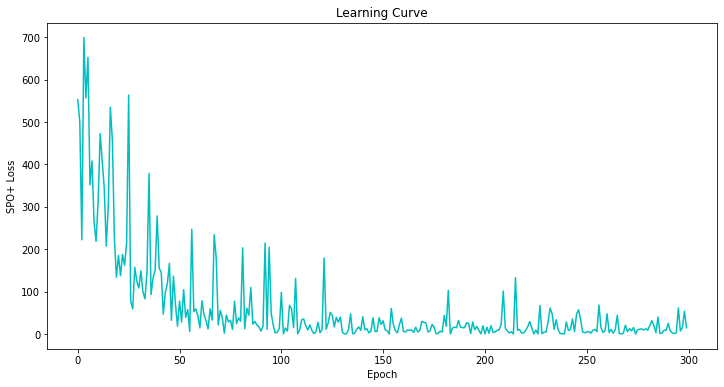

In [23]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

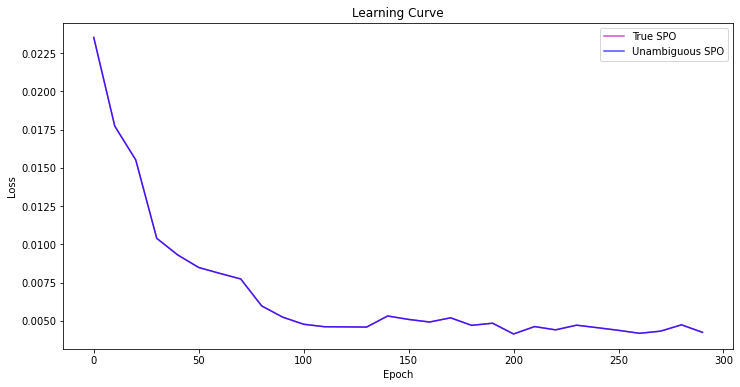

In [24]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluation 

In [25]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.43%
Normalized unambiguous SPO Loss: 0.43%


In [26]:
# compare solutions
reg.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -92.56, -1.94, 11.99, -1.92, 92.33, -94.16, -25.25, 18.46, -1.80, 78.13, -21.76, -106.19, -40.40, 38.61, -22.47, 64.08, -82.53, -21.31, 40.98, -26.36, -33.97, -19.77, 4.32, 41.04, 55.40, -67.65, -27.99, 19.97, 42.15, 123.38, 23.16, -14.21, 14.49, -41.22, 32.44, -1.00, -13.70, -0.43, -40.56, 1.49
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 201.43

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 5

##  Training SPO+ with Regularization

In [27]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [28]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-2)

In [29]:
# init SPO+ loss
criterion = SPOPlus()

In [30]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(sp_model, cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 144.6674, True SPO Loss:  2.3353%, Unambiguous SPO Loss:  2.3353%
Epoch  20, Loss: 131.1554, True SPO Loss:  1.4775%, Unambiguous SPO Loss:  1.4775%
Epoch  30, Loss: 100.7296, True SPO Loss:  1.3057%, Unambiguous SPO Loss:  1.3057%
Epoch  40, Loss:  27.5997, True SPO Loss:  1.0063%, Unambiguous SPO Loss:  1.0063%
Epoch  50, Loss:  64.1290, True SPO Loss:  0.8610%, Unambiguous SPO Loss:  0.8610%
Epoch  60, Loss: 105.6777, True SPO Loss:  0.6633%, Unambiguous SPO Loss:  0.6633%
Epoch  70, Loss: 216.5997, True SPO Loss:  0.6405%, Unambiguous SPO Loss:  0.6405%
Epoch  80, Loss:  21.5057, True SPO Loss:  0.6629%, Unambiguous SPO Loss:  0.6629%
Epoch  90, Loss:  15.5494, True SPO Loss:  0.5901%, Unambiguous SPO Loss:  0.5901%
Epoch 100, Loss:  17.1944, True SPO Loss:  0.5998%, Unambiguous SPO Loss:  0.5998%
Epoch 110, Loss:   3.9124, True SPO Loss:  0.5751%, Unambiguous SPO Loss:  0.5751%
Epoch 120, Loss:  36.2433, True SPO Loss:  0.4696%, Unambiguous SPO Loss:  0.4696%
Epoc

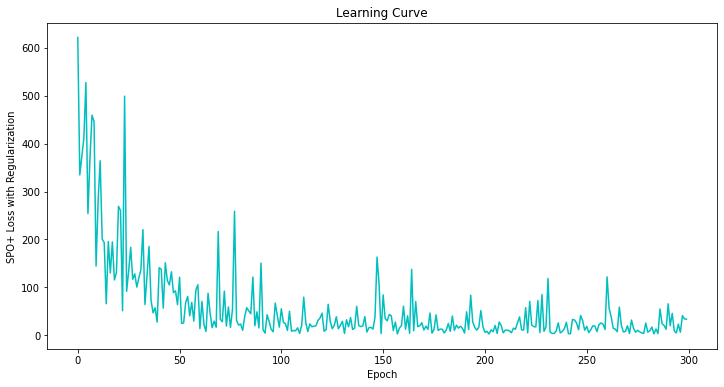

In [31]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss with Regularization')
plt.title('Learning Curve')
plt.show()

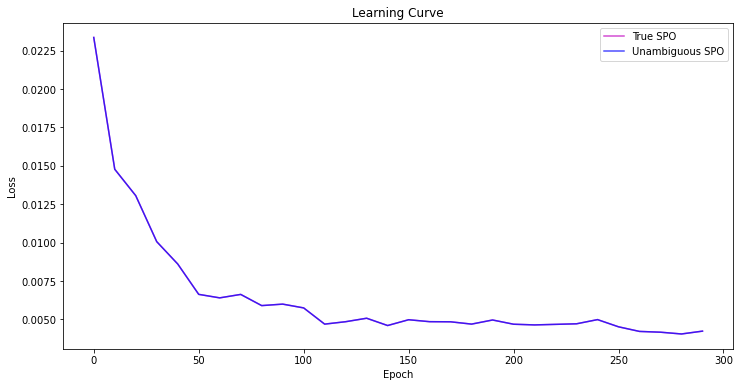

In [32]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluation 

In [33]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.42%
Normalized unambiguous SPO Loss: 0.42%


In [34]:
# compare solutions
reg.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -78.16, -1.97, 19.70, 8.82, 78.58, -80.68, -22.93, -4.14, 12.01, 73.63, -22.59, -92.79, -42.63, 24.73, -17.56, 58.68, -80.25, -10.33, 33.48, -21.97, -29.21, -25.72, -4.15, 36.39, 51.65, -69.35, -22.72, 4.08, 37.91, 112.14, 19.74, -16.51, 15.66, -37.76, 31.58, 2.17, -17.17, 3.54, -36.32, 1.11
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27

## Training Black-Box

In [35]:
from func import blackboxOpt

In [36]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [37]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [38]:
# set loss
criterion = nn.L1Loss()

In [39]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 333.7205, True SPO Loss: 52.0592%, Unambiguous SPO Loss: 52.0592%
Epoch  20, Loss: 347.1831, True SPO Loss: 45.5612%, Unambiguous SPO Loss: 45.5612%
Epoch  30, Loss: 225.2944, True SPO Loss: 38.9428%, Unambiguous SPO Loss: 38.9428%
Epoch  40, Loss: 168.2130, True SPO Loss: 31.0491%, Unambiguous SPO Loss: 31.0491%
Epoch  50, Loss: 144.3148, True SPO Loss: 24.7169%, Unambiguous SPO Loss: 24.7169%
Epoch  60, Loss: 102.5308, True SPO Loss: 19.1018%, Unambiguous SPO Loss: 19.1018%
Epoch  70, Loss: 233.3828, True SPO Loss: 15.7092%, Unambiguous SPO Loss: 15.7092%
Epoch  80, Loss:  70.1959, True SPO Loss: 12.3269%, Unambiguous SPO Loss: 12.3269%
Epoch  90, Loss: 153.0626, True SPO Loss: 10.6635%, Unambiguous SPO Loss: 10.6635%
Epoch 100, Loss:  47.2338, True SPO Loss:  7.6179%, Unambiguous SPO Loss:  7.6179%
Epoch 110, Loss:  14.5733, True SPO Loss:  5.4116%, Unambiguous SPO Loss:  5.4116%
Epoch 120, Loss:   5.8605, True SPO Loss:  4.6161%, Unambiguous SPO Loss:  4.6161%
Epoc

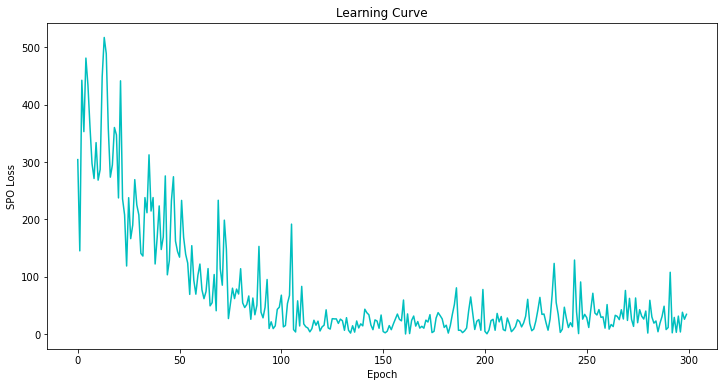

In [40]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

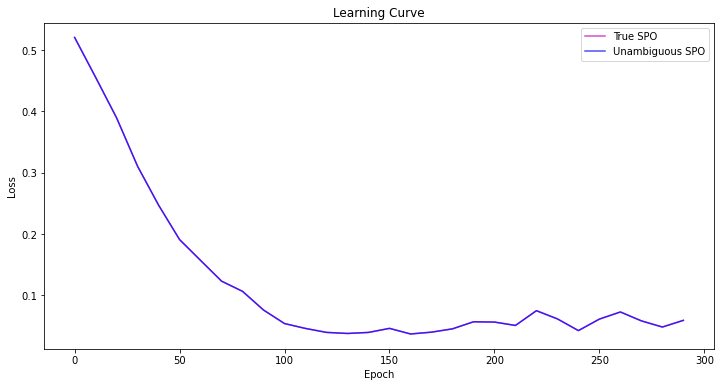

In [41]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluation 

In [42]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 5.94%
Normalized unambiguous SPO Loss: 5.94%


In [43]:
# compare solutions
reg.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -0.40, -0.21, -0.52, -0.91, 0.52, 0.62, 0.56, 0.26, 0.41, -0.30, -0.27, -1.03, -0.56, -0.79, -0.39, -0.57, 0.63, 0.30, 0.10, -0.45, 0.18, -0.55, -0.26, -0.02, 0.16, -0.73, -0.38, 0.34, -0.27, -0.71, -0.54, 0.62, 0.86, 0.05, 0.63, 0.16, 0.19, -0.69, -0.13, -1.02
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, Pred obj: 220.04

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.29

## Training Black-Box with Regularization

In [44]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [45]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-4)

In [46]:
# set loss
criterion = nn.L1Loss()

In [47]:
# train model
num_epochs = 300
lambd = 10
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(sp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = blackboxOpt.apply(sp_model, cp, lambd)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = trueSPO(reg, sp_model, sp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = unambSPO(reg, sp_model, sp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 251.4319, True SPO Loss: 44.2603%, Unambiguous SPO Loss: 44.2603%
Epoch  20, Loss: 292.0048, True SPO Loss: 39.6735%, Unambiguous SPO Loss: 39.6735%
Epoch  30, Loss: 164.2736, True SPO Loss: 34.4143%, Unambiguous SPO Loss: 34.4143%
Epoch  40, Loss: 100.8430, True SPO Loss: 29.3738%, Unambiguous SPO Loss: 29.3738%
Epoch  50, Loss: 120.1061, True SPO Loss: 23.6848%, Unambiguous SPO Loss: 23.6848%
Epoch  60, Loss: 197.5948, True SPO Loss: 17.3595%, Unambiguous SPO Loss: 17.3595%
Epoch  70, Loss:  39.6188, True SPO Loss: 12.0209%, Unambiguous SPO Loss: 12.0209%
Epoch  80, Loss:  58.2850, True SPO Loss:  9.2705%, Unambiguous SPO Loss:  9.2705%
Epoch  90, Loss:  73.6229, True SPO Loss:  6.8449%, Unambiguous SPO Loss:  6.8449%
Epoch 100, Loss:  12.7217, True SPO Loss:  5.8775%, Unambiguous SPO Loss:  5.8775%
Epoch 110, Loss:  25.2666, True SPO Loss:  5.2620%, Unambiguous SPO Loss:  5.2620%
Epoch 120, Loss:  25.6838, True SPO Loss:  4.5856%, Unambiguous SPO Loss:  4.5856%
Epoc

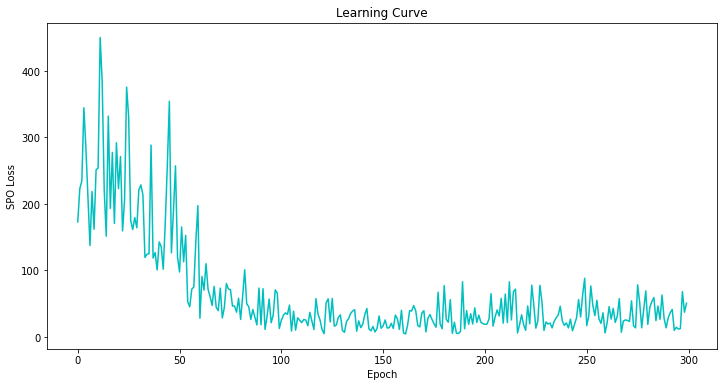

In [48]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO Loss')
plt.title('Learning Curve')
plt.show()

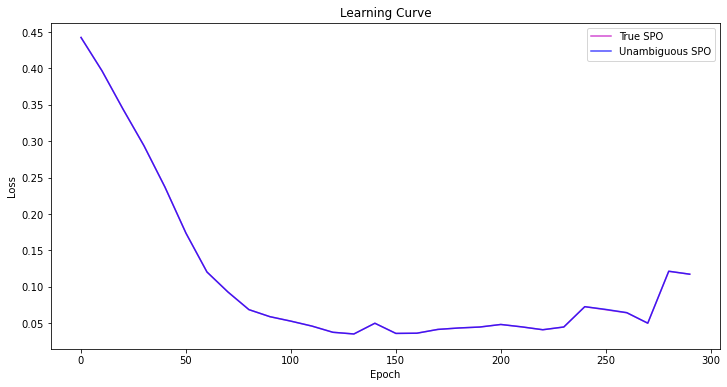

In [49]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## Evaluation 

In [50]:
# evaluate
spoloss = trueSPO(reg, sp_model, sp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = unambSPO(reg, sp_model, sp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 11.72%
Normalized unambiguous SPO Loss: 11.72%


In [51]:
# compare solutions
reg.eval()
loss = []
# load data
for i, data in enumerate(sp_loader_test):
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    c = c.to('cpu').detach().numpy().tolist()
    w = w.to('cpu').detach().numpy().tolist()
    z = z.to('cpu').detach().numpy().tolist()
    cp = cp.to('cpu').detach().numpy().tolist()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        sp_model.setObj(cp[j])
        wpj, _ = sp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j][0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 35.78, 26.44, 82.00, 4.47, 120.99, 13.57, 9.10, 32.00, 14.31, 50.36, 13.57, 25.84, 5.78, 32.00, 10.80, 32.00, 2.86, 37.30, 22.91, 13.57, 25.84, 37.30, 59.39, 21.15, 105.33, 9.10, 10.80, 10.80, 54.85, 61.69, 44.51, 5.78, 44.51, 26.44, 82.00, 61.69, 9.10, 61.69, 18.65, 37.30
    Pred cost: -0.95, -0.08, 1.18, 0.23, -0.36, 0.25, 0.13, -0.18, -0.26, -0.34, -0.20, 0.49, 0.53, 0.03, -0.37, 0.54, 0.40, -0.41, -0.73, 0.70, 0.36, -0.24, 0.46, 0.52, -0.07, -0.94, -1.19, -0.51, 0.11, -0.51, -0.55, -0.07, 0.29, 0.05, -0.48, -0.29, -0.25, -0.08, -1.05, -0.35
    True sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, True obj: 201.43
    Pred sol: 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, Pred obj: 206.94

Sample 1:
    True cost: 1.41, 99.22, 82.00, 19.81, 13.06, 2.75, 12.75, 55.24, 9.98, 50.27, 2.75, 6.06, 8.38, 55.24, 7.2